In [36]:
import warnings
warnings.filterwarnings("ignore")

import scanpy as sc
import pandas as pd
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor="white")

In [37]:
# import bbknn
import scib
import scvi

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc


In [38]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

In [39]:
# Load PBMC data
adata_ref = sc.datasets.pbmc3k_processed()
adata = sc.datasets.pbmc68k_reduced()

In [40]:
adata_ref

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [41]:
adata

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [42]:
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]

In [43]:
adata_ref

View of AnnData object with n_obs × n_vars = 2638 × 208
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [44]:
adata

View of AnnData object with n_obs × n_vars = 700 × 208
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fedad0509a0>
Traceback (most recent call last):
  File "/ihome/crc/install/python/ondemand-jupyter-python3.11-2023.09/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/ihome/crc/install/python/ondemand-jupyter-python3.11-2023.09/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/ihome/crc/install/python/ondemand-jupyter-python3.11-2023.09/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/ihome/crc/install/python/ondemand-jupyter-python3.11-2023.09/lib/python3.11/site-packages

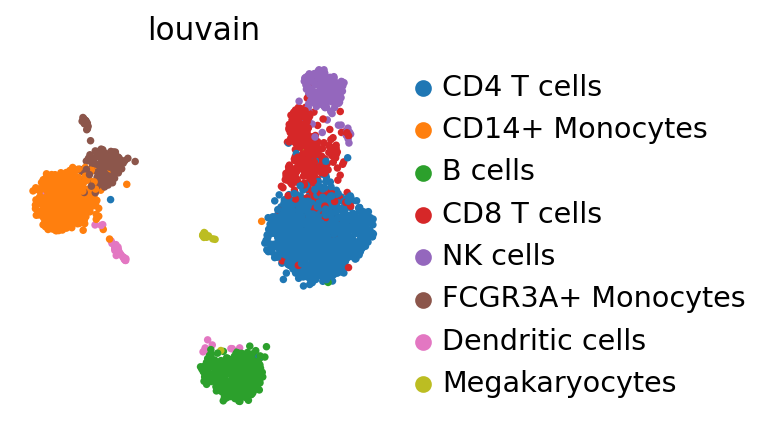

In [45]:
# preprocessing
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)
sc.pl.umap(adata_ref, color="louvain")

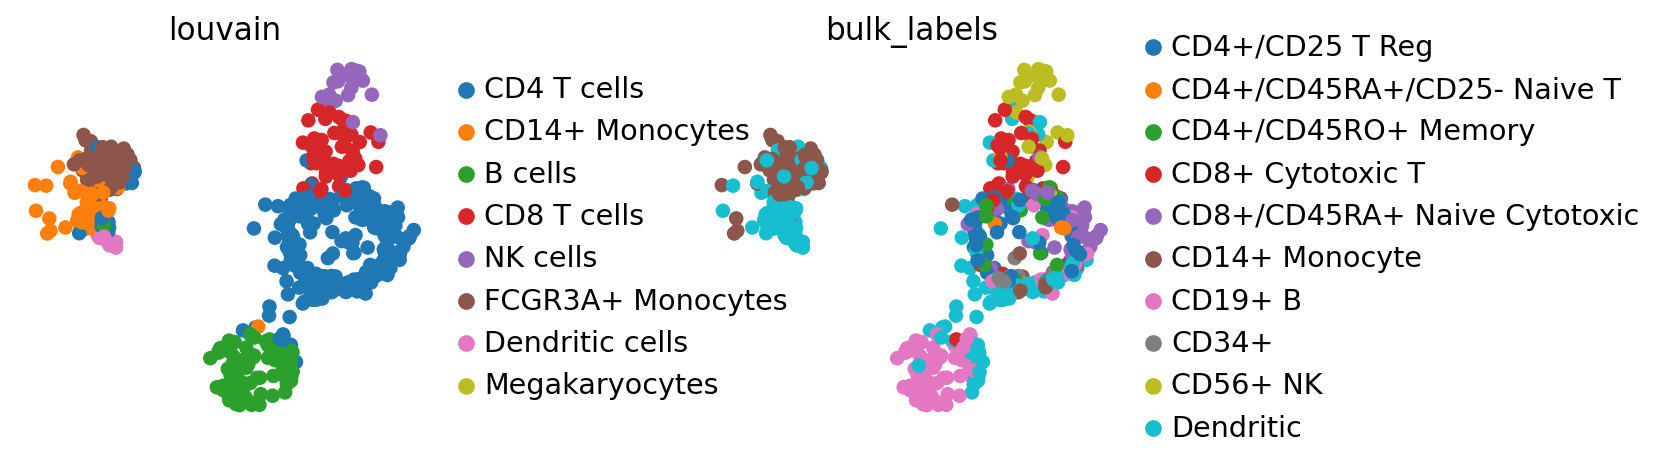

In [46]:
sc.tl.ingest(adata, adata_ref, obs="louvain")
adata.uns["louvain_colors"] = adata_ref.uns["louvain_colors"]  # fix colors
sc.pl.umap(adata, color=["louvain", "bulk_labels"], wspace=0.5)

In [47]:
adata_concat = adata_ref.concatenate(adata, batch_categories=["ref", "new"])
adata_concat

AnnData object with n_obs × n_vars = 3338 × 208
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'bulk_labels', 'S_score', 'G2M_score', 'phase', 'batch'
    var: 'n_counts-new', 'means-new', 'dispersions-new', 'dispersions_norm-new', 'highly_variable-new', 'n_cells-ref'
    obsm: 'X_pca', 'X_umap'

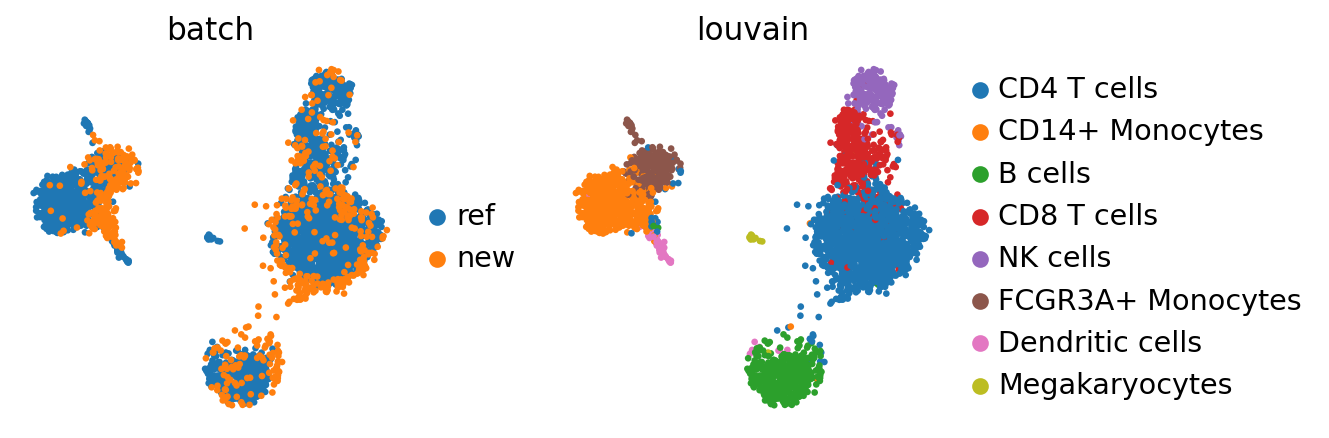

In [48]:
adata_concat.obs.louvain = adata_concat.obs.louvain.astype("category")
# fix category ordering
adata_concat.obs.louvain.cat.reorder_categories(
    adata_ref.obs.louvain.cat.categories)
# fix category colors
adata_concat.uns["louvain_colors"] = adata_ref.uns["louvain_colors"]
sc.pl.umap(adata_concat, color=["batch", "louvain"])

# Pancreas data

In [49]:
!pwd
!ls

/ihome/ylee/yiz133/Code/ScanPy_examples
BBKNN_Integrating.ipynb		integrating spatial with scanorama.ipynb
cite_doublet_removal_xdbt.h5mu	pancreas.h5ad
data				Preprocessing.ipynb
example.h5ad			Trajectory Inference.ipynb


In [50]:
# note that this collection of batches is already intersected on the genes
adata_all = sc.read(
    "pancreas.h5ad",
    backup_url="https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1",
)


In [51]:
adata_all

AnnData object with n_obs × n_vars = 14693 × 2448
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
    uns: 'celltype_colors', 'louvain', 'neighbors', 'pca', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [52]:
counts = adata_all.obs.celltype.value_counts()
counts
# remove the 5 minority classes
minority_classes = counts.index[-5:].tolist()  # get the minority classes
adata_all = adata_all[~adata_all.obs.celltype.isin(minority_classes)]  # actually subset
adata_all.obs.celltype.cat.reorder_categories(  # reorder according to abundance
    counts.index[:-5].tolist())

index
human1_lib1.final_cell_0001-0     acinar
human1_lib1.final_cell_0002-0     acinar
human1_lib1.final_cell_0003-0     acinar
human1_lib1.final_cell_0004-0     acinar
human1_lib1.final_cell_0005-0     acinar
                                  ...   
reads.29499-3                     ductal
reads.29500-3                     ductal
reads.29501-3                       beta
reads.29502-3                    dropped
reads.29503-3                       beta
Name: celltype, Length: 14662, dtype: category
Categories (19, object): ['alpha', 'beta', 'ductal', 'acinar', ..., 'co-expression', 'mast', 'epsilon', 'mesenchyme']

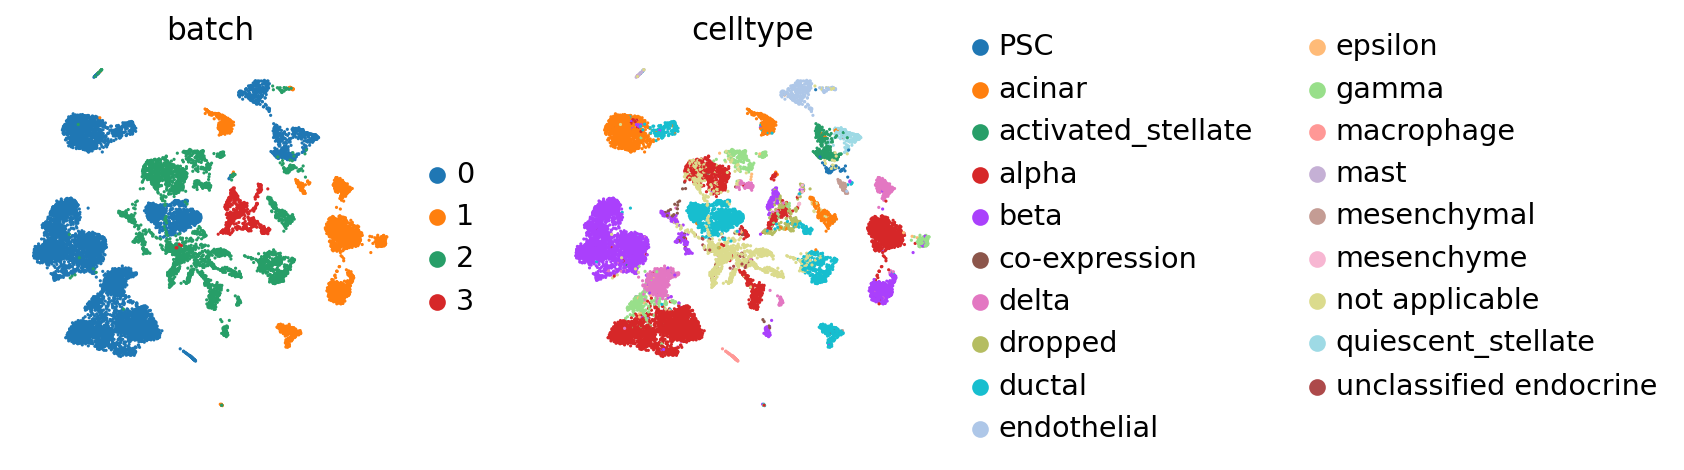

In [53]:
# the batch effect
sc.pp.pca(adata_all)
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)
sc.pl.umap(
    adata_all, color=["batch", "celltype"], palette=sc.pl.palettes.vega_20_scanpy
)

In [54]:
# solve with BBKNN
import sys
sys.path.append('/ihome/ylee/yiz133/Code/Data processing/')
import bbknn

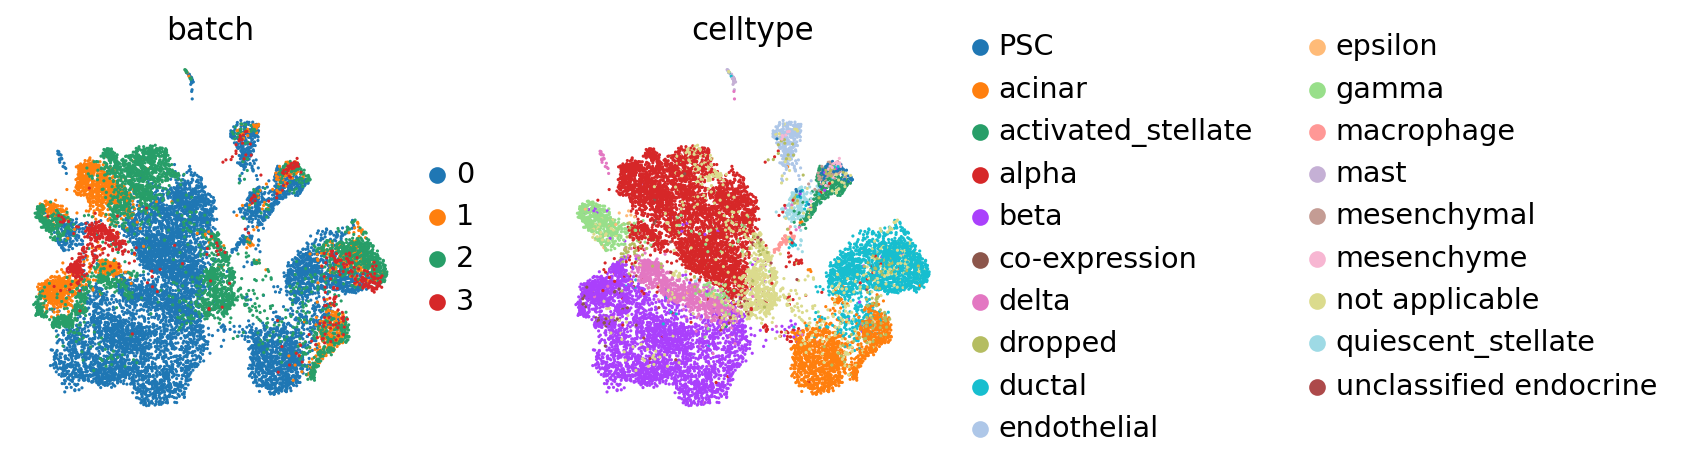

In [55]:
bbknn.bbknn(adata_all, batch_key="batch",  use_annoy=False)
sc.tl.umap(adata_all)
sc.pl.umap(adata_all, color=["batch", "celltype"])

# Harmony integrate

In [57]:
adata_all

AnnData object with n_obs × n_vars = 14662 × 2448
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
    uns: 'celltype_colors', 'louvain', 'neighbors', 'pca', 'sample_colors', 'umap', 'batch_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [58]:
sc.external.pp.harmony_integrate(adata_all, "batch")

2025-06-26 18:51:53,795 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fedc904d3a0>
Traceback (most recent call last):
  File "/ihome/crc/install/python/ondemand-jupyter-python3.11-2023.09/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/ihome/crc/install/python/ondemand-jupyter-python3.11-2023.09/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/ihome/crc/install/python/ondemand-jupyter-python3.11-2023.09/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  

In [59]:
adata_all

AnnData object with n_obs × n_vars = 14662 × 2448
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
    uns: 'celltype_colors', 'louvain', 'neighbors', 'pca', 'sample_colors', 'umap', 'batch_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

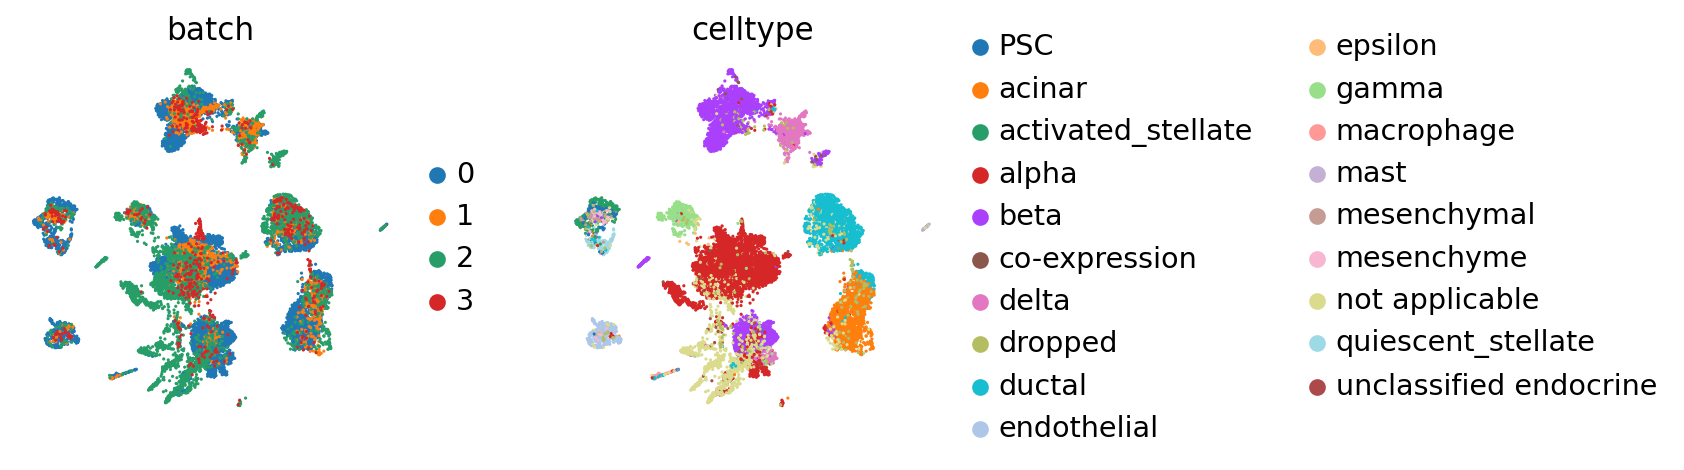

In [62]:
sc.pp.neighbors(adata_all, use_rep='X_pca_harmony')
sc.tl.umap(adata_all)
sc.pl.umap(adata_all, color=["batch", "celltype"])

# Mapping onto a reference batch using ingest

/ihome/ylee/yiz133/.local/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


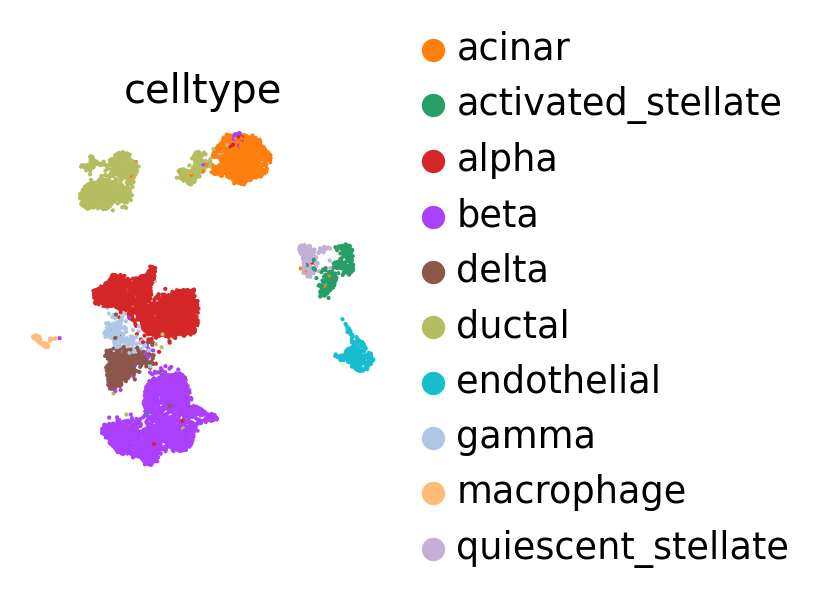

In [27]:
adata_ref = adata_all[adata_all.obs.batch == "0"]
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)
sc.pl.umap(adata_ref, color="celltype")

In [28]:
adata_ref

AnnData object with n_obs × n_vars = 8506 × 2448
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
    uns: 'celltype_colors', 'louvain', 'neighbors', 'pca', 'sample_colors', 'umap', 'batch_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [29]:
adatas = [adata_all[adata_all.obs.batch == i].copy() for i in ["1", "2", "3"]]
sc.settings.verbosity = 2  # a bit more logging
for iadata, adata in enumerate(adatas):
    print(f"... integrating batch {iadata+1}")
    adata.obs["celltype_orig"] = adata.obs.celltype  # save the original cell type
    sc.tl.ingest(adata, adata_ref, obs="celltype")

... integrating batch 1
running ingest


/ihome/ylee/yiz133/.local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    finished (0:00:04)
... integrating batch 2
running ingest


/ihome/ylee/yiz133/.local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    finished (0:00:05)
... integrating batch 3
running ingest


/ihome/ylee/yiz133/.local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


    finished (0:00:03)


In [30]:
adatas

[AnnData object with n_obs × n_vars = 2119 × 2448
     obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain', 'celltype_orig'
     var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
     uns: 'celltype_colors', 'louvain', 'neighbors', 'pca', 'sample_colors', 'umap', 'batch_colors'
     obsm: 'X_pca', 'X_umap', 'rep'
     varm: 'PCs'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 3262 × 2448
     obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain', 'celltype_orig'
     var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
     uns: 'celltype_colors', 'louvain', 'neighbors', 'pca', 'sample_colors', 'umap', 'batch_colors'
     obsm: 'X_pca', 'X_umap', 'rep'
     varm: 'PCs'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 608 × 2448
     obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain', 'celltype_orig'
     var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
     

In [31]:
adata_ref

AnnData object with n_obs × n_vars = 8506 × 2448
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
    uns: 'celltype_colors', 'louvain', 'neighbors', 'pca', 'sample_colors', 'umap', 'batch_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [32]:
adata_concat = adata_ref.concatenate(adatas)
adata_concat

/scratch/slurm-5693280/ipykernel_13442/1585337123.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = adata_ref.concatenate(adatas)


AnnData object with n_obs × n_vars = 14495 × 2448
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain', 'celltype_orig'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
    obsm: 'X_pca', 'X_umap'

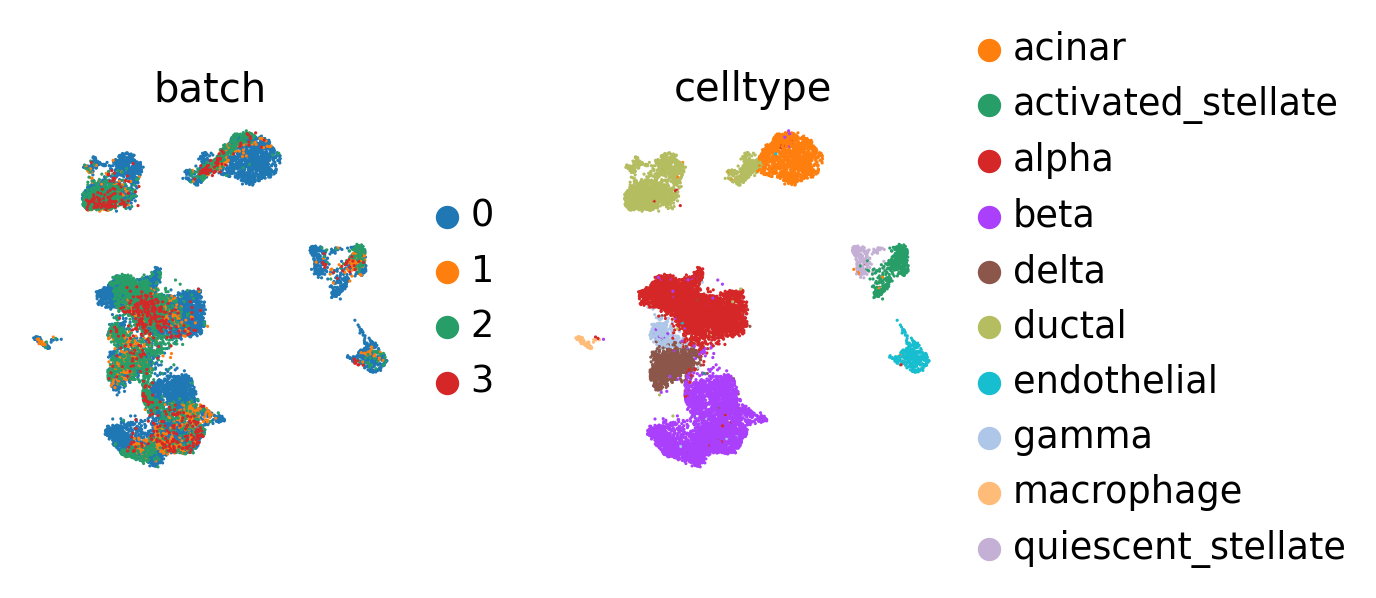

In [33]:
adata_concat.obs.celltype = adata_concat.obs.celltype.astype("category")
# fix category ordering
adata_concat.obs.celltype.cat.reorder_categories(
    adata_ref.obs.celltype.cat.categories)
# fix category coloring
adata_concat.uns["celltype_colors"] = adata_ref.uns["celltype_colors"]
sc.pl.umap(adata_concat, color=["batch", "celltype"])

## Evaluating consistency

In [34]:
adata_query = adata_concat[adata_concat.obs.batch.isin(["1", "2", "3"])]
adata_query.obs

,celltype,sample,n_genes,batch,n_counts,louvain,celltype_orig
index,,,,,,,
D28.1_1-1-1,alpha,Muraro,5448,1,2.322583e+04,8,alpha
D28.1_13-1-1,ductal,Muraro,5911,1,2.334263e+04,19,ductal
D28.1_15-1-1,alpha,Muraro,5918,1,2.713471e+04,8,alpha
D28.1_17-1-1,alpha,Muraro,4522,1,1.581207e+04,8,alpha
D28.1_2-1-1,endothelial,Muraro,6464,1,3.173151e+04,17,endothelial
...,...,...,...,...,...,...,...
reads.29499-3-3,ductal,Wang,19950,3,1.056558e+06,10,ductal
reads.29500-3-3,ductal,Wang,19950,3,9.926309e+05,10,ductal
reads.29501-3-3,beta,Wang,19950,3,1.751338e+06,10,beta


In [35]:
obs_query.celltype.cat.categories

NameError: name 'obs_query' is not defined

In [ ]:
obs_query = adata_query.obs
# intersected categories
conserved_categories = obs_query.celltype.cat.categories.intersection(
    obs_query.celltype_orig.cat.categories
)
# intersect categories
obs_query_conserved = obs_query.loc[
    obs_query.celltype.isin(conserved_categories)
    & obs_query.celltype_orig.isin(conserved_categories)
]


In [ ]:
obs_query_conserved.celltype.cat.remove_unused_categories()
obs_query_conserved.celltype.cat.categories

In [ ]:
obs_query_conserved.celltype_orig.cat.categories

In [ ]:
obs_query_conserved.celltype_orig.cat.remove_unused_categories()
obs_query_conserved.celltype_orig.cat.categories

In [ ]:
pd.crosstab(obs_query_conserved.celltype, obs_query_conserved.celltype_orig)

## Visualizing distributions across batche

In [ ]:
sc.tl.embedding_density(adata_concat, groupby="batch")
sc.pl.embedding_density(adata_concat, groupby="batch")

In [ ]:
for batch in ["1", "2", "3"]:
    sc.pl.umap(adata_concat, color="batch", groups=[batch])